Input shape: [ 1 96 96  3]


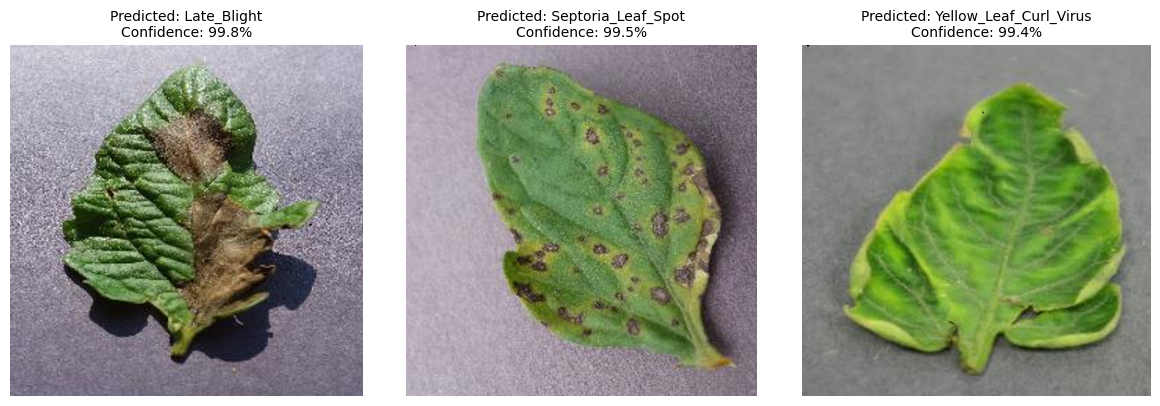

In [ ]:
# Import required libraries
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/ei-tomato-leaf-disease-transfer-learning-tensorflow-lite-float32-model.7.lite")  # Replace with your actual file
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Check input shape expected by model
input_shape = input_details[0]['shape']
print("Input shape:", input_shape)  # e.g., [1, 96, 96, 3]

# Load and preprocess image
def preprocess_image(image_path, target_shape):
    img = Image.open(image_path).convert("RGB").resize((target_shape[1], target_shape[2]))
    img_array = np.array(img).astype(np.float32)

    # Normalize if required (Edge Impulse uses [0, 255] range or [0,1] depending on model)
    if input_details[0]['dtype'] == np.float32:
        img_array = img_array / 255.0

    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Class names for prediction
class_names = [
    "Late_Blight",
    "Leaf_Mold",
    "Septoria_Leaf_Spot",
    "Spider_Mites",
    "Yellow_Leaf_Curl_Virus"
]

# Run inference and display class name
def classify_image(image_path):
    input_data = preprocess_image(image_path, input_shape)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    predicted_index = int(np.argmax(output_data))
    predicted_class = class_names[predicted_index]
    confidence = output_data[0][predicted_index] * 100

    # Show image and prediction
    plt.imshow(Image.open(image_path))
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.show()

def classify_images_grid(image_paths, cols=3):
    rows = (len(image_paths) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    for idx, image_path in enumerate(image_paths):
        # Prepare image
        input_data = preprocess_image(image_path, input_shape)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])

        predicted_index = int(np.argmax(output_data))
        predicted_class = class_names[predicted_index]
        confidence = output_data[0][predicted_index] * 100

        # Load and plot image
        img = Image.open(image_path)
        ax = axs[idx // cols, idx % cols] if rows > 1 else axs[idx % cols]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Predicted: {predicted_class}\nConfidence: {confidence:.1f}%", fontsize=10)

    # Hide unused subplots
    for j in range(idx + 1, rows * cols):
        ax = axs[j // cols, j % cols] if rows > 1 else axs[j % cols]
        ax.axis('off')

    plt.tight_layout()
    plt.show()


image_list = ["tomato_1.png", "tomato_2.png", "tomato_3.png"]
classify_images_grid(image_list, cols=3)